In [2]:
import sys

print(sys.executable)

/anaconda3/bin/python


In [10]:
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
import george
from george import kernels
import numpy as np
from lightkurve import KeplerTargetPixelFile
import matplotlib.pyplot as pl
import flaredetect as fd
from astropy.io import fits
from scipy.signal import savgol_filter as sf
from scipy.optimize import minimize
from numpy import asarray
import pandas as pd
import scipy.ndimage.filters as gausFilter
from astropy.stats import LombScargle
from scipy.integrate import simps

class Flare:
    flux = []
    time = []

    def __init__(self, x, y, r1, r2):

        self.flux = y[r1:r2]
        self.time = x[r1:r2]

    def getpeaktimes(self):
        return fd.flaredetecttime(self.time, self.flux)

    def guesspeaks(self):  # gathers the peaks in the set of data, then returns a list of flare times, peaks, and fwhm
        self.detflares = fd.flaredetectpeak(self.flux)
        self.flarecount = fd.getlength()
        self.nflares = np.shape(self.detflares)[0]
        self.params = np.zeros([self.nflares, 3])
        for i, flareVal in enumerate(self.detflares):
            self.flarepeak = flareVal
            self.flaretime = self.findfluxtime(self.flarepeak, self.flux, self.time)
            p = [self.flaretime, 0.004, self.flarepeak]
            self.params[i, :] = p
        return np.log(self.params)

    def findfluxtime(self, flarepeak, flux, time):  # retrieves the time of the flare
        tof = time
        for i, flare in enumerate(flux):
            if flare == flarepeak:
                return tof[i]

    def getmodel(self, p, data):  # computes the model of the flares using appaloosa's aflare1 function
        time, y, nflares = data
        p = np.exp(p)
        model = np.zeros_like([time])
        p = np.reshape(p, (nflares, 3))
        for i in range(nflares):
            model += ap.aflare1(time, tpeak=p[i, 0], fwhm=p[i, 1], ampl=p[i, 2], upsample=False, uptime=10)
        return model


1397


<IPython.core.display.Javascript object>


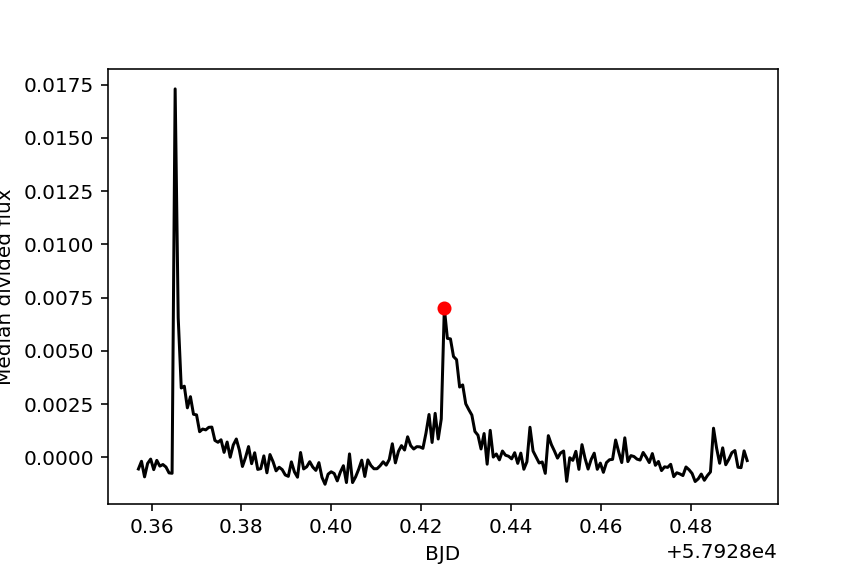

In [13]:
%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
import os
import time
global glob_temp
tracker = 2
temp = 350
flux = 0
time = 0

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

# Simple mouse click function to store coordinates
def onclick(event):
    global timeVar
    global tracker
    global temp
    global time
    global flux
    global coords
    global prevVar
    global peaks
    global time_peaks
    
    timeVar = event.xdata
    coords.append(timeVar)
    if (len(coords) == tracker-1):
        pl.clf()
        pl.xlabel("BJD (start time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.axvline(x=timeVar)
        prevVar = timeVar
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
        
    if len(coords) == tracker:
        pl.clf()
        pl.xlabel("BJD (end time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.axvline(x=timeVar)
        pl.axvline(x=prevVar)
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
        if timeVar != prevVar:
            startIndex = np.where(flare.time == find_nearest(flare.time, prevVar))
            endIndex = np.where(flare.time == find_nearest(flare.time, timeVar))
            peaks.append(time_peaks[np.logical_and(time_peaks > flare.time[startIndex], time_peaks < flare.time[endIndex])])
        
    if len(coords) == (tracker+1):
        temp = temp+1
        pl.clf()
        pl.xlabel("BJD (end time)")
        pl.ylabel("Median divided flux")
        index = np.where(flare.time == time_peaks[temp])[0][0]  # get event index as an int
        start = index - 100
        end = index + 100
        pl.plot(flare.time[start:end], flare.flux[start:end], color='black')
        pl.plot(flare.time[index], flare.flux[index], marker='o', color='Red')
        pl.draw()
    
        if temp > len(time_peaks):
            fig.canvas.mpl_disconnect(cid)
            pl.clf()
            pl.close()
            
        coords.pop()
        tracker = tracker + 2
            
            
        
        

    return


def manualflare(flux, time, time_peaks):
    num_events = len(time_peaks)
    flux = np.asarray(flux)  # convert to np array
    time = np.asarray(time)
    temp_coord = 0
    index = np.where(time == time_peaks[temp])[0][0]  # get event index as an int
    start = index - 100 
    end = index + 100                
    fig = pl.figure(1)
    ax = fig.add_subplot(111)
    cur_plot = ax.plot(time[start:end], flux[start:end], color='black')  # plot the entire flare event
    ax.plot(time[index], flux[index], marker='o', color='Red')
    pl.xlabel("BJD")
    pl.ylabel("Median divided flux")
    cid = fig.canvas.mpl_connect('button_press_event', onclick) # connect the GUI interface


            
    #cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
#fits_file = fits.open('/Users/Dennis/Desktop/AuMicB/tess2018206045859-s0001-0000000441420236-0120-s_lc.fits')

file = np.genfromtxt("/Users/dennisafa/Downloads/files/tweaked_SC_timeseries.txt", dtype=float, usecols=(0, 1), delimiter=' ')

y = file[:, 1]
x = file[:, 0]

y = y[np.logical_not(np.isnan(y))]
y = [p for p in y if p > 410000 and p < 1000000] # Lot of systematic errors below this threshold (should change for other LC's)
    # y = np.array(y)
    # y = pd.rolling_median(y, 30)
x = x[:len(y)]

flare = Flare(x, y, 0, len(y))
flare.flux = np.array(flare.flux)

smo1 = pd.Series(flare.flux).rolling(100, center=True).median()
smo2 = pd.Series(flare.flux-smo1).rolling(2, center=True).median()
smo1 = np.asarray(smo1)
smo2 = np.asarray(smo2)
y = np.isfinite(smo2)

flare.flux = ((flare.flux[y] - smo1[y]) / np.median(flare.flux))
flare.time = flare.time[:len(flare.flux)]
time_peaks = flare.getpeaktimes()

coords = []
finalTimes = []
peaks = []
tempVal = 0
trackClick = 0
time_peaks = np.asarray(time_peaks)
print(len(time_peaks))
manualflare(flare.flux, flare.time, time_peaks)




In [12]:
finalTimes = []
indexedTimes = []
a_flare = []


for i in range(0, len(coords)-2, 2):
    if coords[i] != coords[i+1]:
        finalTimes.append((coords[i], coords[i+1])) # check for double clicks
                
for i in range(0, len(finalTimes), 1):
    startTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][0])))[0][0]
    endTime = np.where(flare.time == (find_nearest(flare.time, finalTimes[i][1])))[0][0]
    indexedTimes.append((startTime, endTime))
    a_flare.append(np.trapz(flare.flux[startTime:endTime], flare.time[startTime:endTime] * 86400))
        
print(len(finalTimes))
print(peaks)
# Calculate integral
#y_int = np.log10(trapz(flare.flux[ch1[0][0]:ch2[0][0]],flare.time[ch1[0][0]:ch2[0][0]] * 86400))
#print(y_int)

SyntaxError: invalid syntax (<ipython-input-12-e2c14c44d0ee>, line 5)

In [ ]:
exptime = 1. / 24. / 80.
# print(flare.time[len(flare.time)-1] - flare.time[-1])

totdur = float(len(flare.time)) * exptime
duration = np.sort(a_flare)[::-1]

ddx = np.log10(duration)
ddy = (np.arange(len(ddx))) / totdur
pl.plot(ddx, ddy, 'o--', markersize=2, alpha=0.5)
pl.yscale('log')
pl.xlabel('log Equivalent Duration (seconds)')
pl.ylabel('Cumulative Flares per Day')
pl.clf()

E_point = 29.20848418222753

print("Rough energy calc", E_point)

pl.plot(ddx + E_point, ddy, 'o', color='Black', markersize=3, alpha=0.7)
pl.title("Wolf 359 FFD")
pl.yscale('log')
#pl.ylim(1e-20, 1e3)
pl.xlabel('log Flare Energy (erg)')
pl.ylabel('Cumulative Flares per Day')
print(ddy[-1], ddx[-1]+E_point)
print(ddx+E_point)
pl.show()


In [ ]:
with open('wolf359FlareTimesP2.txt', 'w') as f:
    for item in finalTimes:
        f.write("%f %f\n" % item)

In [ ]:
print(flare.time[-1])

In [14]:
import numpy as np
file = np.genfromtxt("wolf359FlareTimes.txt", dtype=float, usecols=(0, 1), delimiter=' ')

start = file[0:, 0]
end = file[0:, 1]

In [25]:
ed = []

flux = np.asarray(flare.flux)
time = np.asarray(flare.time)

flux = flux.tolist()
time = time.tolist()

for i in range(0, len(start)):
    s = np.where(flare.time == (find_nearest(flare.time, start[i])))[0][0]
    e = np.where(flare.time == (find_nearest(flare.time, end[i])))[0][0]
    a_flare = np.trapz(flare.flux[s:e], flare.time[s:e] * 86400)
    ed.append(a_flare)
    

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Rough energy calc 29.2


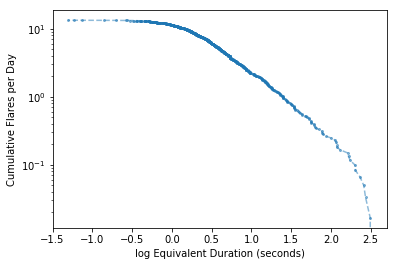

In [38]:
%matplotlib inline

exptime = 1. / 24. / 80.
# print(flare.time[len(flare.time)-1] - flare.time[-1])

totdur = float(len(flare.time)) * exptime
duration = np.sort(ed)[::-1]

ddx = np.log10(duration)
ddy = (np.arange(len(ddx))) / totdur
pl.plot(ddx, ddy, 'o--', markersize=2, alpha=0.5)
pl.yscale('log')
pl.xlabel('log Equivalent Duration (seconds)')
pl.ylabel('Cumulative Flares per Day')


E_point = 29.2

print("Rough energy calc", E_point)






806
[31.72096047 31.69560636 31.63644193 31.61383782 31.56687969 31.50951527
 31.5027438  31.44393488 31.4220424  31.41251933 31.31911503 31.27393511
 31.27315386 31.26584519 31.24879895 31.19937255 31.13493413 31.10546373
 31.09109012 31.08543918 31.04948238 31.00929003 30.99457012 30.98988779
 30.98317865 30.95604849 30.94958648 30.94574986 30.93074474 30.93055686
 30.89463704 30.88678729 30.87008907 30.83813878 30.83506639 30.80709823
 30.79808138 30.78712474 30.77699059 30.7527386  30.74673362 30.74197309
 30.73992294 30.73124309 30.73093909 30.71307099 30.70863022 30.70370724
 30.69472344 30.6863908  30.6630748  30.65220665 30.64976178 30.6454761
 30.64197663 30.63228868 30.62015807 30.60407605 30.59654793 30.5965246
 30.59645403 30.59618097 30.58663995 30.57953479 30.57257221 30.56644362
 30.56437275 30.55813222 30.5535943  30.54711259 30.53533906 30.52782818
 30.5178911  30.51171821 30.49919563 30.48431576 30.48179547 30.46678249
 30.4648986  30.46217435 30.45743484 30.45406177 

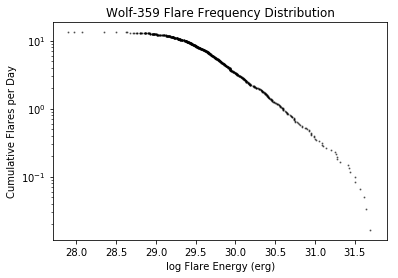

In [39]:
ddx = ddx[~np.isnan(ddx)]
ddx = ddx[~np.isinf(ddx)]
ddy = ddy[:len(ddx)]

pl.plot(ddx + E_point, ddy, 'o', color='Black', markersize=1, alpha=0.5)
pl.title("Wolf-359 Flare Frequency Distribution")
pl.yscale('log')
#pl.ylim(1e-20, 1e3)
pl.xlabel('log Flare Energy (erg)')
pl.ylabel('Cumulative Flares per Day')
print(len(ddx))
print(ddx + E_point)
#pl.savefig('FFDQual.svg', format='svg', dpi=1200)
